# Predicting Fire Damage
Our dataset is the [Forest Fires Data Set](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) from UCI Machine Learning Repository. In this project, our goal is to use a linear regression model to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data. The dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

The features in the dataset are:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

**Import Libraries**

In [144]:
import warnings
warnings.simplefilter(action='ignore')

# EDA Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')

# ML Libraries
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from yellowbrick.model_selection import FeatureImportances
from sklearn.decomposition import PCA

**Load & Preview Dataset**

In [145]:
df = pd.read_csv('fires.csv').drop(columns=['Unnamed: 0'])
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


In [147]:
df.isnull().sum()

X         0
Y         0
month     0
day       0
FFMC     48
DMC      21
DC       43
ISI       2
temp     21
RH       30
wind     35
rain     32
area      0
dtype: int64

**Instantiate Model**

In [148]:
model = LinearRegression()

### Data Processing

**The Area Feature - Logarithm Transform**

In [149]:
df['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

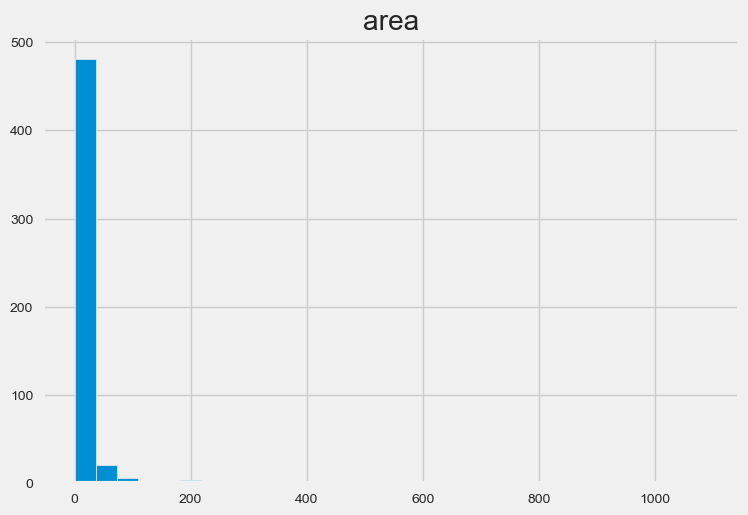

In [150]:
df.hist("area", bins=30)

The output is very right-skewed toward 0.0. It makes sense to model wiht a log-transform of the variable. Because some outcomes are actually 0, so we will add 1 to prevent any errors.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

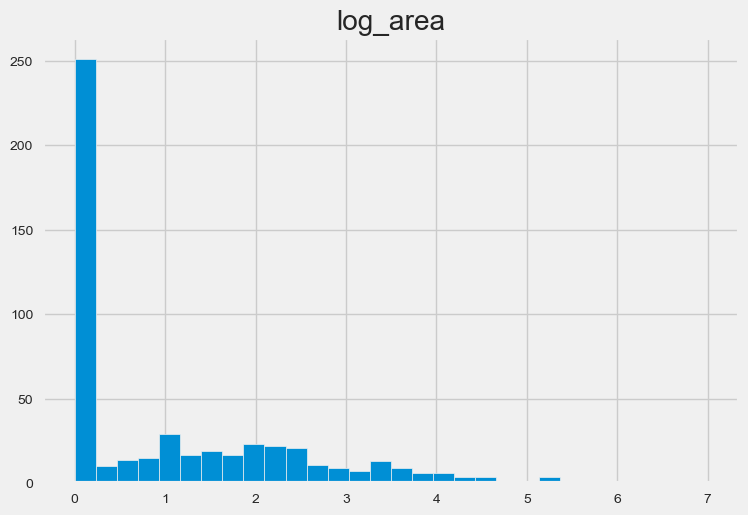

In [151]:
df["log_area"] = np.log(df["area"] + 1)
df.hist("log_area", bins=30)

While performing a log-transformation doesn't produce a bell-shaped distribution, it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

**Month & Day Features**

Fires are more prevalent in the hotter summer months. We'll create a new feature from the month column that segments each record by whether it is summer.

In [152]:
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [153]:
summer_months = ['may', 'jun', 'jul', 'aug']
df['is_summer'] = df['month'].apply(lambda x: 1 if x in summer_months else 0)

df[['month', 'is_summer']].sample(10)

,month,is_summer
315,sep,0
177,aug,1
85,sep,0
475,jun,1
337,sep,0
108,sep,0
289,jul,1
489,aug,1
324,sep,0
515,aug,1


**Impute Missing Data**

We found we have missing data in a number of fields. The KNNImputer class from sklearn helps us impute values into missing fields in more than one column.

In [154]:
missing_cols = list(df.columns[4:-3])
missing_cols

['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [155]:
df_missing = df[missing_cols]

imp = KNNImputer(missing_values=np.nan, n_neighbors=3)
imp_df = pd.DataFrame(imp.fit_transform(df_missing),
                       columns = missing_cols)

imp_df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0


**Outliers**
From the visuals below, there are no significant outliers in the dataset.

<AxesSubplot:>

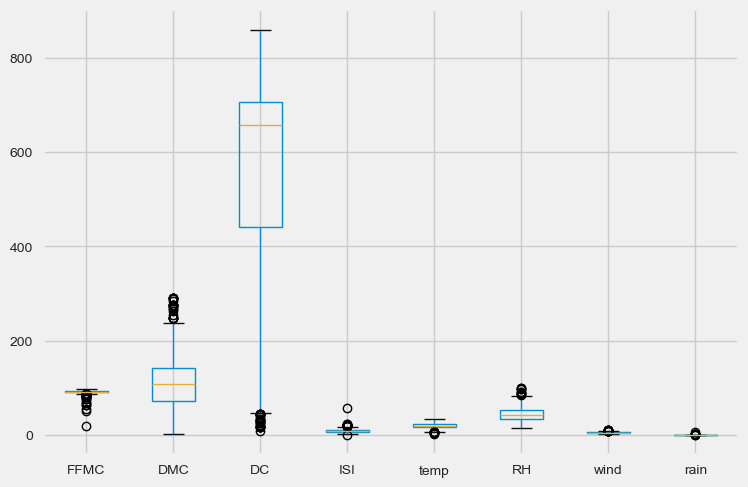

In [156]:
imp_df.boxplot()

**Standardize The Data**

All the record values in the fields are in the same range, except those in DMC and DC. We'll have to standardize the data for modeling.

In [157]:
scaler = StandardScaler()
scaled = scaler.fit_transform(imp_df)
scaled = pd.DataFrame(scaled, columns=missing_cols)

scaled.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268


In [158]:
df_final = pd.concat([df['is_summer'], scaled], axis=1)
df_final.head()

,is_summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268


### Data Visualization

We've used scatter plots below to examine the relationship between each column and the area field. We've chosen scatter plots because they're the number 1 plot for comparing 2 numeric variables.

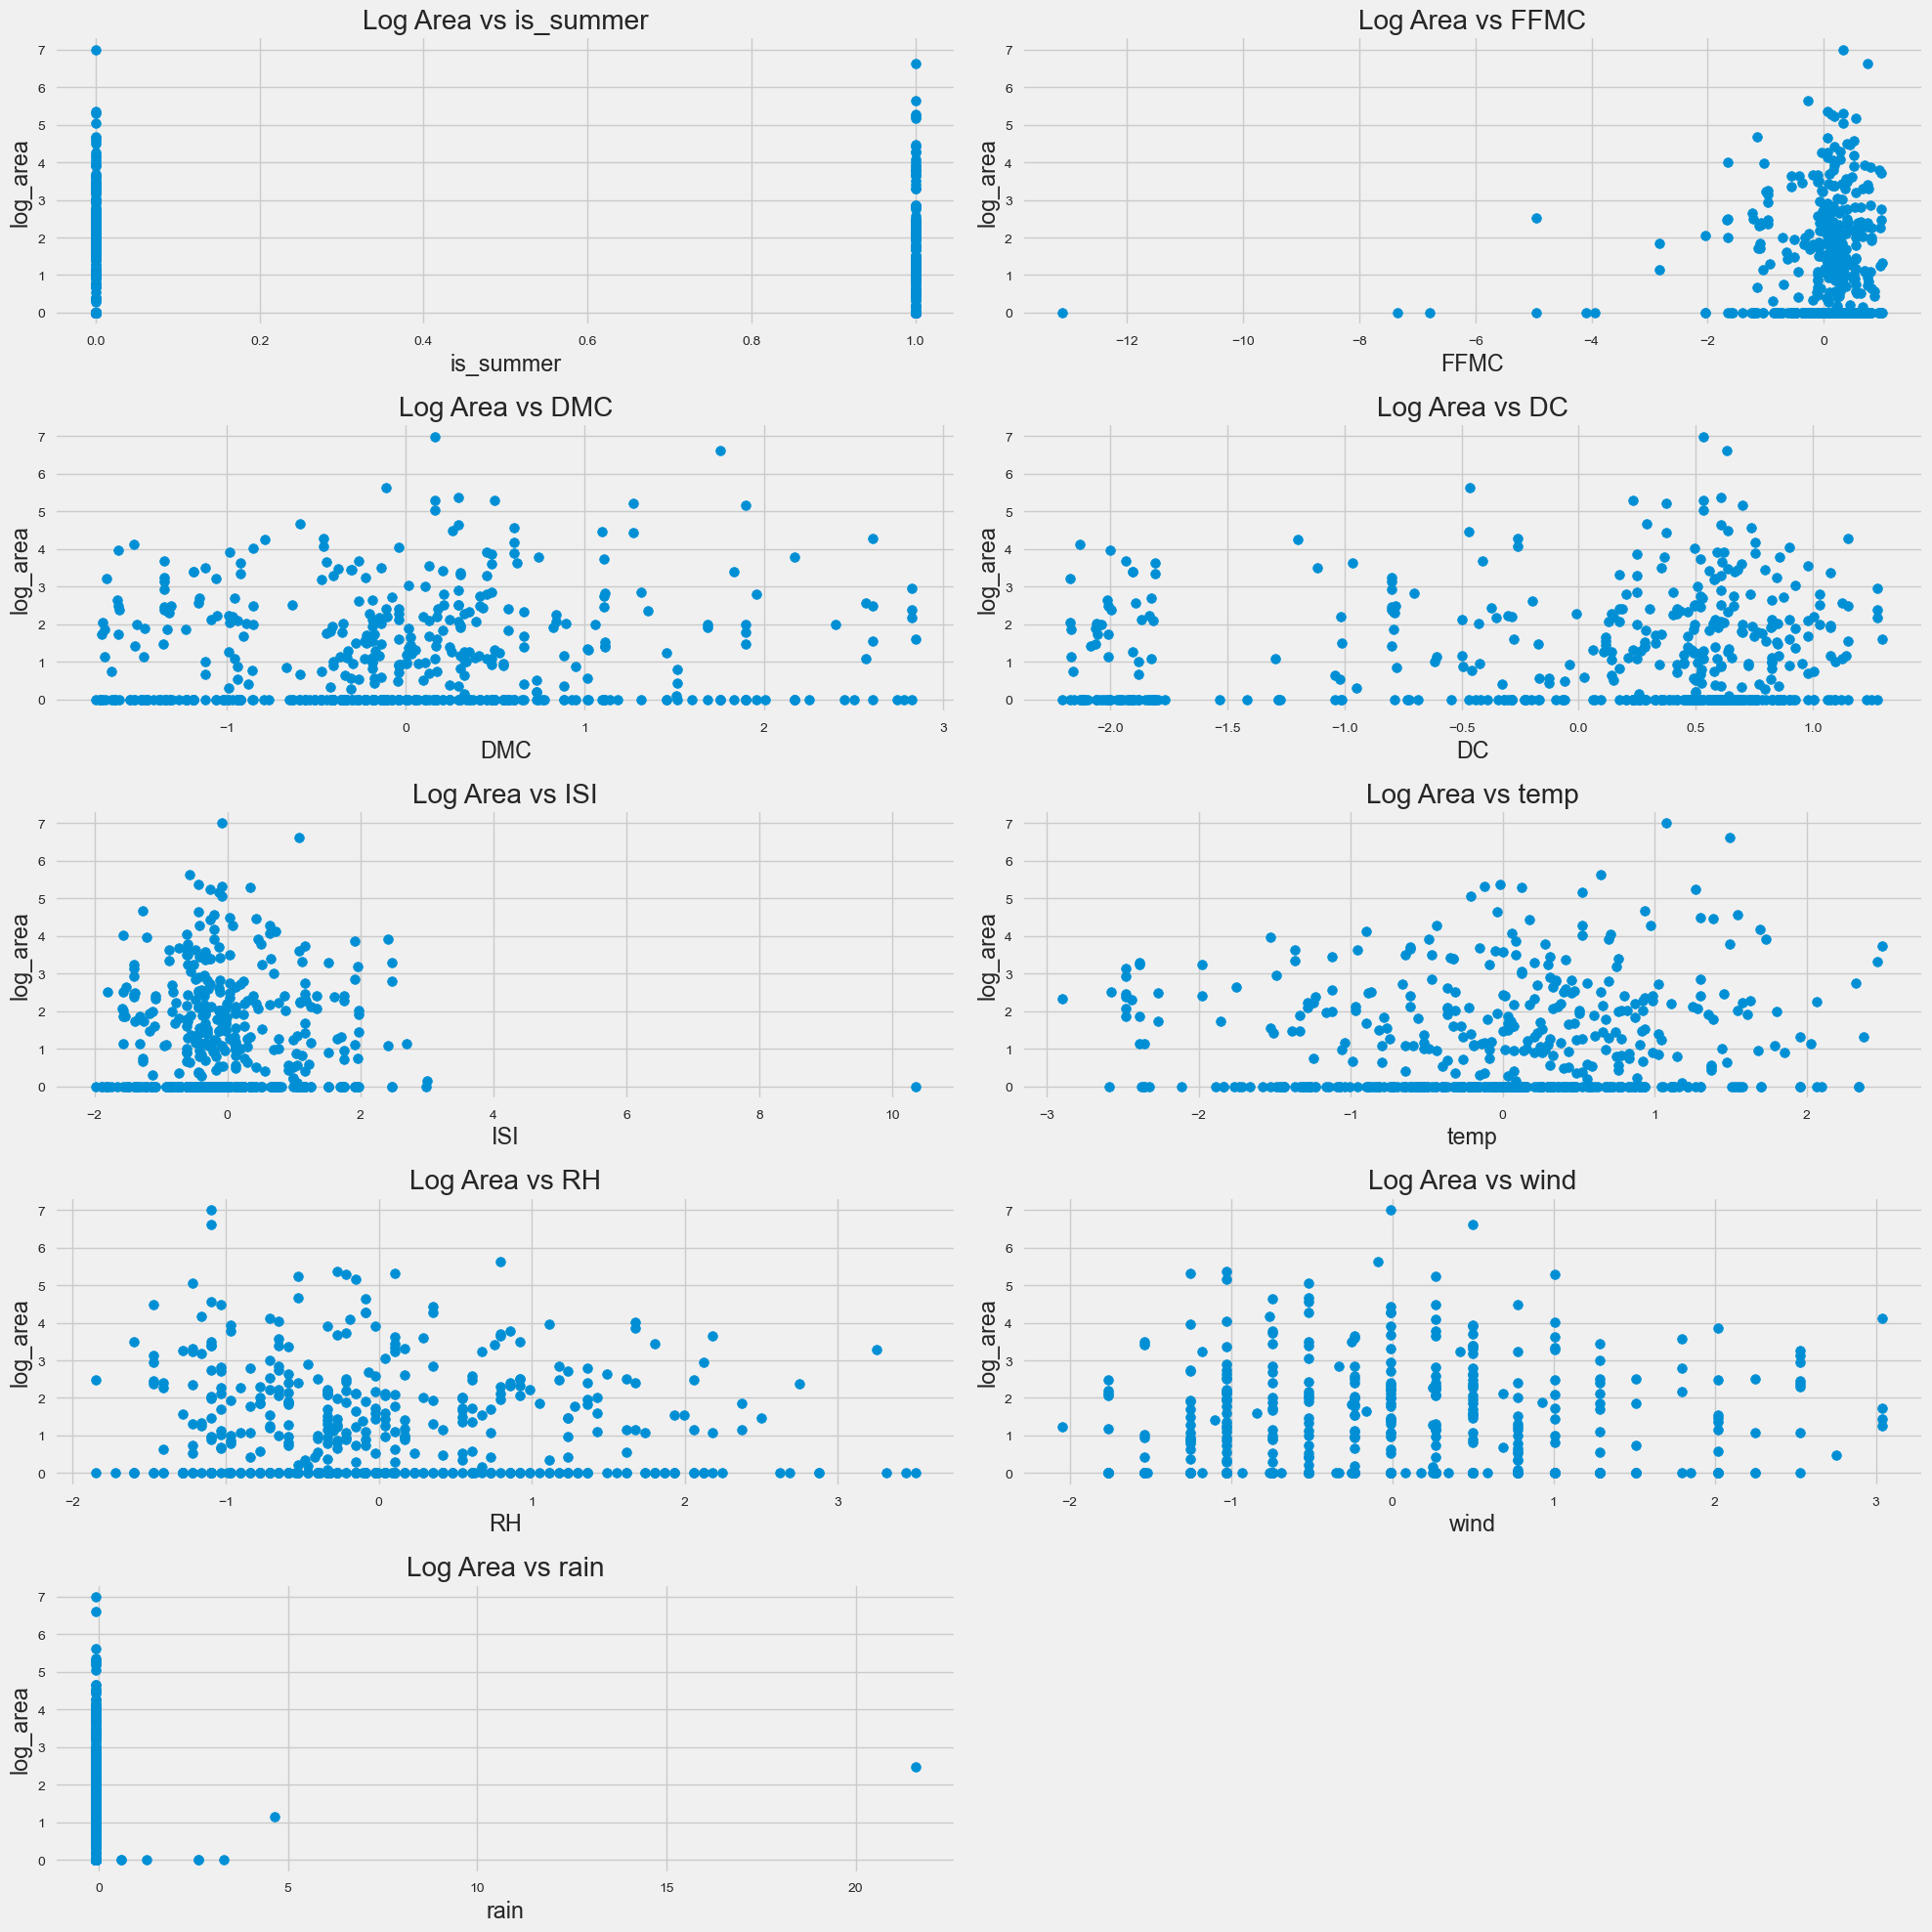

In [159]:
plt.figure(figsize=(20,20))
plot_num = list(range(1,10))
df_cols = list(df_final.columns)

for num, col in zip(plot_num, df_cols):
    plt.subplot(5, 2, num)
    plt.scatter(df_final[col], df['log_area'])
    plt.xlabel(col)
    plt.ylabel('log_area')
    plt.title(f'Log Area vs {col}')

plt.tight_layout()
plt.show()

### Subset Selection

We'll use forward and backward sequential feature selection to determine which features might be useful for generating predictions. This is a purely data-driven approach to choosing a model based on feature importance, so it can help inform our process for creating an initial model that we can improve upon.

We'll begin by creating our X, y variables.

In [160]:
X = df_final
y = df['log_area']

In [161]:
forward = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=4,
                                    direction="forward")
forward.fit(X, y)
forward_features = forward.get_feature_names_out()
print(forward_features)

['FFMC' 'DC' 'RH' 'wind']


In [162]:
backward = SequentialFeatureSelector(estimator=model,
                                     n_features_to_select=4,
                                     direction="backward")
backward.fit(X, y)
backward_features = backward.get_feature_names_out()
print(backward_features)

['FFMC' 'DC' 'RH' 'wind']


Both forward and backward selections pick the same 5 variables.

### Developing Candidate Models

The models chosen by subset selection are still linear models at heart, and they may not be the best solution to this problem. Despite their widespread utility, some problems have a non-linear component that standard linear regression models can't account for. We'll incorporate 2 more flexible models: polynomials and splines. It's important to note that this extra flexibility comes at a price: an increased chance of overfitting.

We'll split our dataset into training and test sets and develop polynomial, spline, ridge and lasso regression models.

**Two-Degree Polynomial**

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=763)
poly = PolynomialFeatures(degree=2, include_bias=False)
quad_X_train = poly.fit_transform(X_train)
quad_X_test = poly.fit_transform(X_test)

In [164]:
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_mse = mean_squared_error(y_test, linear.predict(X_test))

linear_mse

2.265558519701522

In [165]:
quadratic = LinearRegression()
quadratic.fit(quad_X_train, y_train)
quadratic_mse = mean_squared_error(y_test, quadratic.predict(quad_X_test))

quadratic_mse

2.4158225455421025

The mean squared error of the linear model is lower than that of the 2-degree polynomial.

**Cubic Splines**

In [166]:
test_mses = list()
test_mses_dict = dict()

for i in range(2, 11):
    spline = SplineTransformer(degree=3, n_knots=i)
    spline_X_train = spline.fit_transform(X_train)
    spline_X_test = spline.fit_transform(X_test)
    spline_model = LinearRegression()
    spline_model.fit(spline_X_train, y_train)
    test_mses.append(round(mean_squared_error(y_test, spline_model.predict(spline_X_test))))
    test_mses_dict[i] = round(mean_squared_error(y_test, spline_model.predict(spline_X_test)))

test_mses_dict

{2: 2,
 3: 3,
 4: 21226,
 5: 3600063224957231616,
 6: 2315577606742704652288,
 7: 32318034852691260211200,
 8: 4827348530683743731449856,
 9: 1034809446744196380622848,
 10: 62793342853060291599532032}

The optimum knot for cubic spline is 2, with an mse of 2.

**Ridge Regression Model**

In [167]:
ridge_model = RidgeCV(alphas=np.linspace(1, 10000, num=1000))
ridge_model.fit(X_train, y_train)

ridge_model.alpha_

561.5045045045046

In [168]:
ridge_model.coef_

array([-0.02563118,  0.03070822,  0.03185324,  0.00452694, -0.04281028,
        0.01291709, -0.03427383,  0.04651872,  0.01611316])

The MSE for the ridge model is slightly higher than the Cubic Spline Model.

**LASSO Model**

In [169]:
lasso_model = LassoCV(alphas=np.linspace(1, 10, num=100))
lasso_model.fit(X_train, y_train)

lasso_model.alpha_

10.0

In [170]:
lasso_model.coef_

array([-0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.])

The Lasso Model won't work since it's requiring that we use no features.

**Feature Importances**

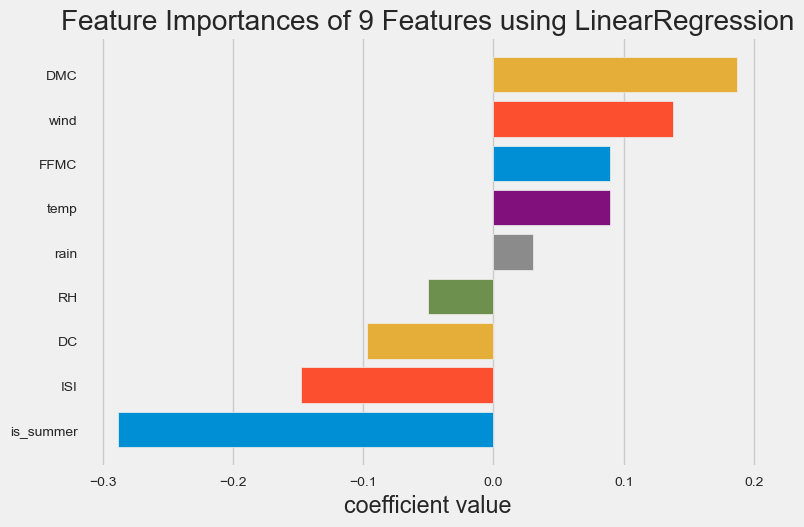

<AxesSubplot:title={'center':'Feature Importances of 9 Features using LinearRegression'}, xlabel='coefficient value'>

In [171]:
fi_model = LinearRegression()

viz = FeatureImportances(fi_model,relative=False)

viz.fit(X_train, y_train)
viz.show()

### K-Fold Cross Validation

We'll use K-Fold to compare our model MSEs and determine the best model.

In [172]:
lin_m = LinearRegression()
seq_m = LinearRegression()
quad_m = LinearRegression()
spline_model = LinearRegression()
ridge_model = RidgeCV(alphas=561)
fi_model = LinearRegression()

In [173]:
linear_cv = cross_val_score(lin_m, X[['wind', 'temp']], y, cv=5, scoring="neg_mean_squared_error")

print("Linear Model, Avg Test MSE: ", np.mean(linear_cv))
print("Linear Model, Avg Test St. Dev.: ", np.std(linear_cv))

Linear Model, Avg Test MSE:  -2.204650013004116
Linear Model, Avg Test St. Dev.:  1.060040355378637


In [174]:
seq_cv = cross_val_score(seq_m, X[backward.get_feature_names_out()], y, cv=5, scoring="neg_mean_squared_error")

print("Sequential Features Model, Avg Test MSE: ", np.mean(seq_cv))
print("Sequential Features Model, Avg Test St. Dev.: ", np.std(seq_cv))

Sequential Features Model, Avg Test MSE:  -2.193528106772711
Sequential Features Model, Avg Test St. Dev.:  1.0004774710977682


In [175]:
quad_X = poly.fit_transform(X)
quad_cv = cross_val_score(seq_m, quad_X, y, cv=5, scoring="neg_mean_squared_error")


print("Quadratic Model, Avg Test MSE: ", np.mean(quad_cv))
print("Quadratic Model, Avg Test St. Dev.: ", np.std(quad_cv))

Quadratic Model, Avg Test MSE:  -34.30073284634245
Quadratic Model, Avg Test St. Dev.:  62.88808039727252


In [176]:
spline = SplineTransformer(degree=3, n_knots=2)
spline_X = spline.fit_transform(X)
spline_cv = cross_val_score(spline_model, spline_X, y, cv=5, scoring="neg_mean_squared_error")

print("Cubic Spline Model, Avg Test MSE: ", np.mean(spline_cv))
print("Cubic Spline Model, Avg Test St. Dev.: ", np.std(spline_cv))

Cubic Spline Model, Avg Test MSE:  -2.8937634784728426e+23
Cubic Spline Model, Avg Test St. Dev.:  5.787526956945685e+23


In [177]:
ridge_cv = cross_val_score(ridge_model, X, y, cv=5, scoring="neg_mean_squared_error")

print("Ridge Model, Avg Test MSE: ", np.mean(ridge_cv))
print("Ridge Model, Avg Test St. Dev.: ", np.std(ridge_cv))

Ridge Model, Avg Test MSE:  -2.2114781350118937
Ridge Model, Avg Test St. Dev.:  1.0500811970972987


In [178]:
fi_cv = cross_val_score(fi_model, X[['wind', 'DC']], y, cv=5, scoring="neg_mean_squared_error")

print("Feature Importances Model, Avg Test MSE: ", np.mean(fi_cv))
print("Feature Importances, Avg Test St. Dev.: ", np.std(fi_cv))

Feature Importances Model, Avg Test MSE:  -2.173357302739327
Feature Importances, Avg Test St. Dev.:  1.0038109503795958


In [183]:
fi2_cv = cross_val_score(fi_model, X[['DMC', 'wind', 'FFMC', 'temp', 'rain']], y, cv=5, scoring="neg_mean_squared_error")

print("Feature Importances Model, Avg Test MSE: ", np.mean(fi2_cv))
print("Feature Importances, Avg Test St. Dev.: ", np.std(fi2_cv))

Feature Importances Model, Avg Test MSE:  -2.6118511481458873
Feature Importances, Avg Test St. Dev.:  1.3297940590278166


The sequential features model has the best MSE and is the best of the models.

### Examining Model Weaknesses
We'll use the X_test created above to predict values based on the sequential features model. Then we'll calculate the model residuals.

We'll plot the observed outcomes and the predicted values.

Finally, we'll plot the residuals as a function of the predicted values.

In [184]:
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X[['wind', 'DC']], y, test_size=.2, random_state=763)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [185]:
residuals = y_test - y_pred

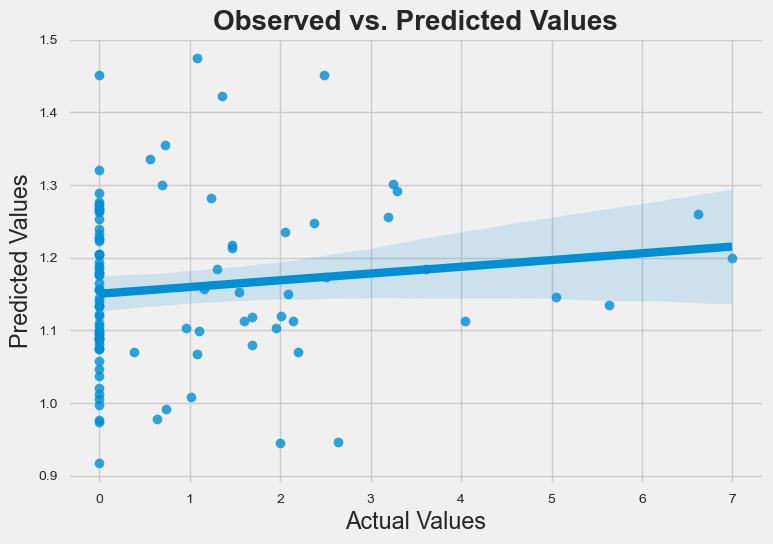

In [188]:
sns.regplot(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs. Predicted Values', weight='bold', size=20)
plt.show()

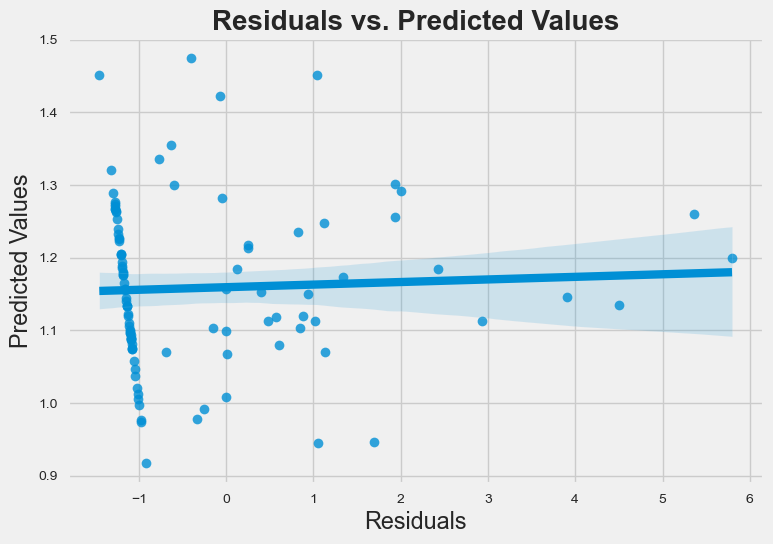

In [189]:
sns.regplot(residuals, y_pred)
plt.xlabel('Residuals')
plt.ylabel('Predicted Values')
plt.title('Residuals vs. Predicted Values', weight='bold', size=20)
plt.show()

There is no linear relationship between the actual and predicted values or the residuals and predicted values.